In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hospital-beds-management/staff.csv
/kaggle/input/hospital-beds-management/patients.csv
/kaggle/input/hospital-beds-management/staff_schedule.csv
/kaggle/input/hospital-beds-management/services_weekly.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

patients = pd.read_csv('/kaggle/input/hospital-beds-management/patients.csv')
patients.head() 

,patient_id,name,age,arrival_date,departure_date,service,satisfaction
0,PAT-09484753,Richard Rodriguez,24,2025-03-16,2025-03-22,surgery,61
1,PAT-f0644084,Shannon Walker,6,2025-12-13,2025-12-14,surgery,83
2,PAT-ac6162e4,Julia Torres,24,2025-06-29,2025-07-05,general_medicine,83
3,PAT-3dda2bb5,Crystal Johnson,32,2025-10-12,2025-10-23,emergency,81
4,PAT-08591375,Garrett Lin,25,2025-02-18,2025-02-25,ICU,76


In [3]:
# Getting more info.
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      1000 non-null   object
 1   name            1000 non-null   object
 2   age             1000 non-null   int64 
 3   arrival_date    1000 non-null   object
 4   departure_date  1000 non-null   object
 5   service         1000 non-null   object
 6   satisfaction    1000 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 54.8+ KB


In [4]:
# A Closer Look at Categorical columns.
patients.value_counts('service')

service
emergency           263
surgery             254
general_medicine    242
ICU                 241
Name: count, dtype: int64

In [5]:
# .describe() Numerical Columns.
patients.describe()

,age,satisfaction
count,1000.000000,1000.000000
mean,45.337000,79.597000
std,25.999912,11.550325
min,0.000000,60.000000
25%,23.000000,70.000000
50%,46.000000,80.000000
75%,68.000000,89.250000
max,89.000000,99.000000


# 1.Exploratory Data Analysis

* Exploring Age and Satisfaction Distributions.

**I have analysed and explored how patient's age's and satisfaction levels are distributed across the hospital dataset. Understanding these distributions helps identify population patterns and potential relationships between patient's age's and satisfaction levels.**

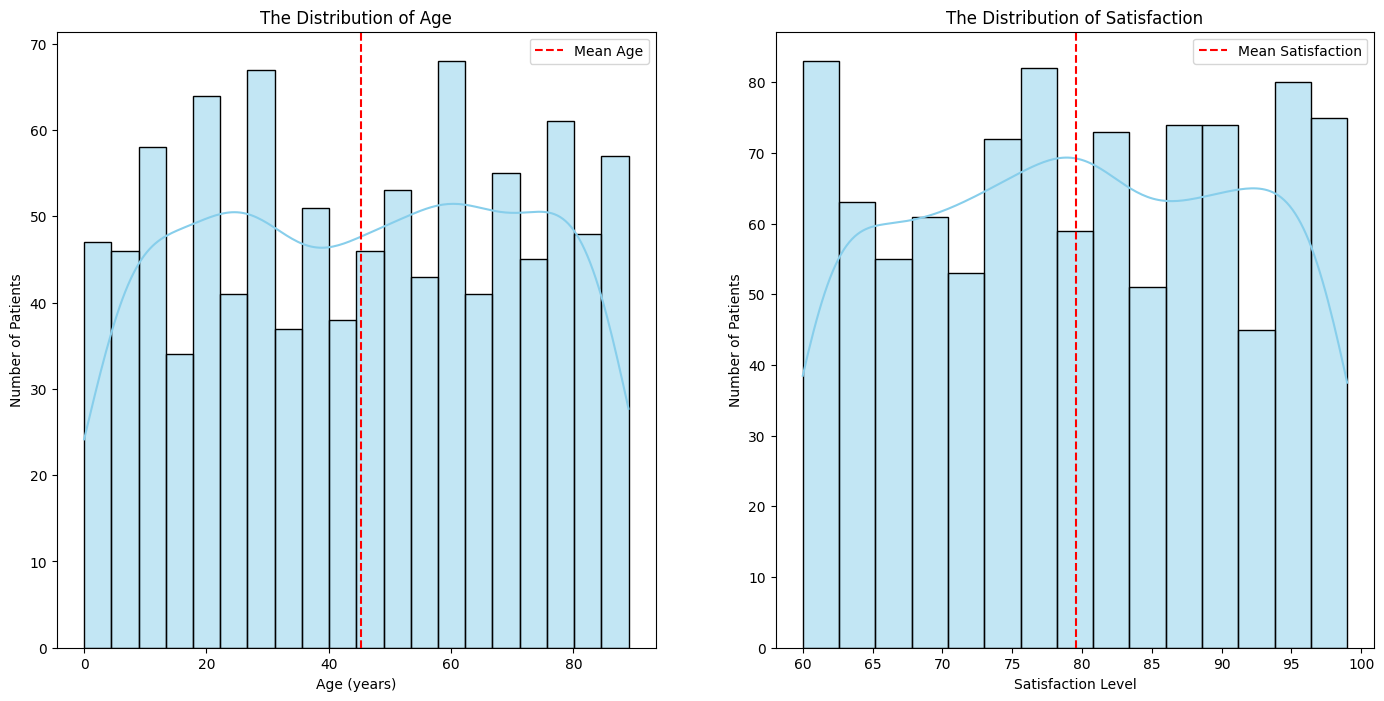

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(17, 8))  #Creats a figure two side-by-side plots(1 row, 2 columns).
                                                 #figsize=(17, 8) Controls the overall width and hieght of the visualazation.

sns.histplot(data=patients, color='skyblue', x='age', kde=True, bins=20, ax=axes[0]).set_title('The Distribution of Age') 
#Uses Seaborn’s histplot() to visualize the age distribution.
#kde=True overlays a Kernel Density Estimate (KDE) curve: a smoothed version of the histogram.
#bins=20 divides the age range into 20 intervals for finer detail.
#The plot is assigned to the first subplot (ax=axes[0]).
#Adds the title “The Distribution of Age.”

#Adds axis labels for readability
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Number of Patients')

#Draws a vertical dashed line at the mean age, helping you compare individual ages to the overall average.
axes[0].axvline(patients['age'].mean(), color='red', linestyle='--', label='Mean Age')

#Adds a legend explaining the red dashed line.
axes[0].legend()

sns.histplot(data=patients, color='skyblue', x='satisfaction', kde=True,bins=15, ax=axes[1]).set_title('The Distribution of Satisfaction')
axes[1].set_xlabel('Satisfaction Level')
axes[1].set_ylabel('Number of Patients')
axes[1].axvline(patients['satisfaction'].mean(), color='red', linestyle='--', label='Mean Satisfaction')
axes[1].legend()

#Displays both subplots side by side.
plt.show() 

> Left Graph: Age Distribution

1. Most patients are clustered in the middle-age range (around 30–60 years).
2. There are fewer younger and older patients, meaning the hospital mainly serves adults, not children or the elderly.
3. The red dashed line (mean age) sits near the center of the peak, suggesting the age data is fairly balanced, not heavily skewed.

> Right Graph: Satisfaction Distribution

1. Most satisfaction scores are high, clustering near the upper end of the scale.
2. The red dashed line (mean satisfaction) is also toward the right, confirming that overall patient satisfaction is strong.
3. The distribution is slightly left-skewed, meaning only a few patients reported low satisfaction.

**patients are mostly adults and are generally very satisfied with their hospital experience.**

* Comparing Satisfactions Across Hospital Services.

**The analysis examines how patients satisfaction scores differ among hospital services (e.g. surgery, general_medicine, etc). By comparing satisfaction scores, hospital services  we can identify which departments perform best in patient experience and where improvements are needed.**

                  count       mean        std   min   25%   50%    75%   max
service                                                                     
ICU               241.0  79.921162  11.723463  60.0  69.0  81.0  90.00  99.0
emergency         263.0  79.547529  11.635225  60.0  70.0  80.0  89.00  99.0
general_medicine  242.0  78.574380  11.125307  60.0  69.0  78.0  88.00  99.0
surgery           254.0  80.314961  11.691489  60.0  71.0  80.0  90.75  99.0


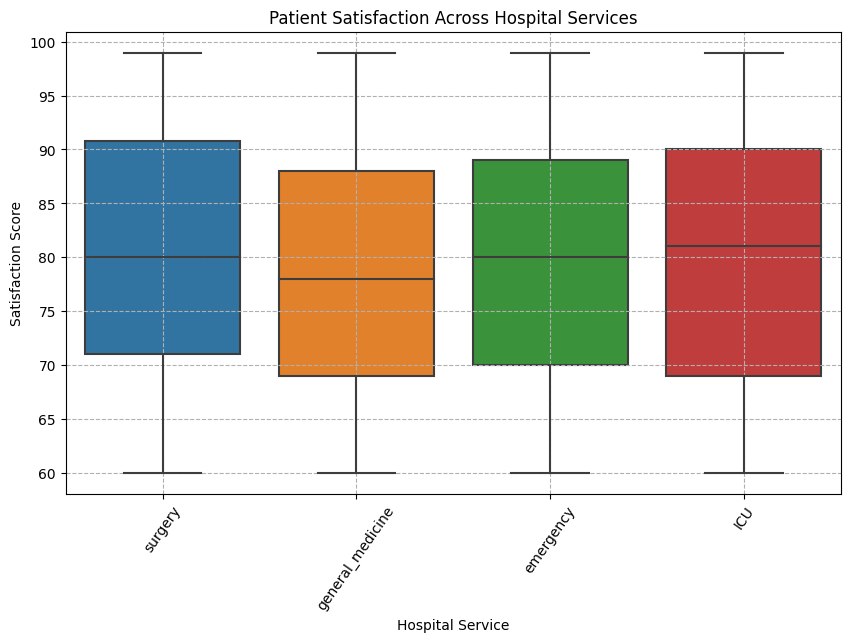

In [7]:
#patients.groupby('service'):Groups the dataset by each hospital service.
#['satisfaction'].describe():Calculates descriptive statistics (count, mean, std, min, 25%,50%,75%, max) for satisfaction within each group.
#summary stores the resulting table, showing satisfaction statistics for every hospital service.
summary = patients.groupby('service')['satisfaction'].describe()
print(summary)

plt.figure(figsize=(10, 6))

sns.boxplot(data=patients, x='service', y='satisfaction')

# Adds labels and title.
plt.title('Patient Satisfaction Across Hospital Services')
plt.xlabel('Hospital Service')
plt.ylabel('Satisfaction Score')

#Adds a faint dashed grid for easier comparison.
plt.grid(True, linestyle='--', alpha=1.0)

#Rotates x-axis labels for readability.
plt.xticks(rotation=55)

#Displays the plot.
plt.show()

* Calculating Average Stay Durations.

**This analysis calculates how long patients typically stay in the hospital — a key operational metric for healthcare efficiency and patient care.
By measuring stay duration, hospital managers can evaluate bed utilization, service efficiency, and discharge processes.**

In [8]:
#pd.to_datetime() converts the arrival_date and departure_date columns from string format (e.g., '2025-03-10') into datetime objects.
#.dropna() removes missing values (NaN) to prevent errors when calculating durations.
patients['arrival_date'] = pd.to_datetime(patients['arrival_date']).dropna() 
patients['departure_date'] = pd.to_datetime(patients['departure_date']).dropna()


#Subtracting two datetime columns gives a timedelta (difference in time).
#The .dt.days attribute extracts the number of days from that time difference.
#The result is stored in a new column: stay_duration.
patients['stay_duration'] = (patients['departure_date'] - patients['arrival_date']).dt.days 

average_stay = patients['stay_duration'].mean() #.mean() calculates the average stay (in days) across all patients.
print(f"Average stay: {average_stay:.2f} days") #The f-string formats the output to two decimal places for readability.

Average stay: 7.41 days


> **The average patient spends about a week in the hospital (7.41 days), a healthy indicator of moderate case complexity and typical inpatient flow.**

* Visualizing Correlations Between Age, Satisfaction and stay duration.

**The analysis examines how key patient variables — age, satisfaction, and stay duration — relate to one another.
By visualizing correlations, we can identify patterns such as whether older patients tend to stay longer or more satisfied patients have shorter stays.**

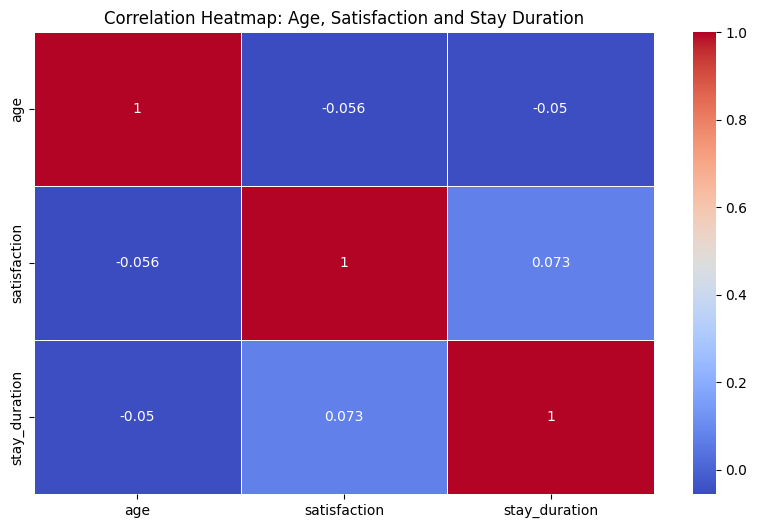

In [9]:
#patients[['age', 'satisfaction', 'stay_duration']]: Selects the three numeric columns of interest.
#.corr(): Computes the correlation matrix — a table showing how strongly each variable is linearly related to the others.
corr_matrix = patients[['age', 'satisfaction', 'stay_duration']].corr()

plt.figure(figsize=(10, 6))

#sns.heatmap(): Creates a color-coded grid showing correlations:
                                                        ## annot=True: displays the numerical correlation values inside each cell.
                                                        ## cmap='coolwarm' : uses blue for negative correlations, red for positive ones.
                                                        ## linewidths=0.5: adds light gridlines for clarity.
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap: Age, Satisfaction and Stay Duration')

#Displays heatmap.
plt.show()

**> Conclusion**

**All three relationships are weakly correlated, meaning:**
1. Age, satisfaction, and stay duration behave largely independently of each other.
 
2. Changes in one variable do not predict changes in the others very well.

# 2.Hypothesis Testing

In [10]:
services_weekly = pd.read_csv('/kaggle/input/hospital-beds-management/services_weekly.csv')
services_weekly.head()

,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event
0,1,1,emergency,32,76,32,44,67,70,none
1,1,1,surgery,45,130,45,85,83,78,flu
2,1,1,general_medicine,37,201,37,164,97,43,flu
3,1,1,ICU,22,31,22,9,84,91,flu
4,2,1,emergency,28,169,28,141,75,64,none


*  Testing Whether Events (like"flu") Significantly Impact Staff Morale.

**This analysis uses hypothesis testing to determine whether flu outbreak events significantly affect staff morale in the hospital.By comparing morale levels during “flu” weeks versus “non-flu” weeks, we can figure out if such events meaningfully influence staff well-being.**



In [11]:
services_weekly = services_weekly[['event', 'staff_morale']]

flu_morale = services_weekly[services_weekly['event'] == 'flu']['staff_morale']
none_flu_morale = services_weekly[services_weekly['event'] == 'none']['staff_morale']

#ttest_ind() performs a two-sample t-test, which tests whether the means of two independent groups are statistically different.
#equal_var=False applies Welch’s t-test, which does not assume equal variance: more robust for real world data.
#Returns:
        ##t_stat: the test statistic.
        ##p_value: probability that observed differences are due to chance.
t_stat, p_value = ttest_ind(flu_morale, none_flu_morale, equal_var=False)
print("t-statistics:", t_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Reject H0: flu events significantly effect staff morale.")
else:
    print("Fail to reject H0: no significant difference in staff morale between flu and none flu weeks.")

t-statistics: -0.06945826968730032
p-value: 0.9452381983531588
Fail to reject H0: no significant difference in staff morale between flu and none flu weeks.


**> conclusion:**

The t-test found no statistically significant difference in staff morale between flu and non-flu weeks (p = 0.945).
Therefore, flu events do not appear to have a measurable impact on staff morale in the dataset.

* Visualizing Average Staff Morale: Flu vs Non-Flu Weeks


**This visualization helps us compare average staff morale between flu and non-flu weeks while also displaying the 95% confidence intervals around the mean estimates. It provides a visual complement to the earlier hypothesis test.**

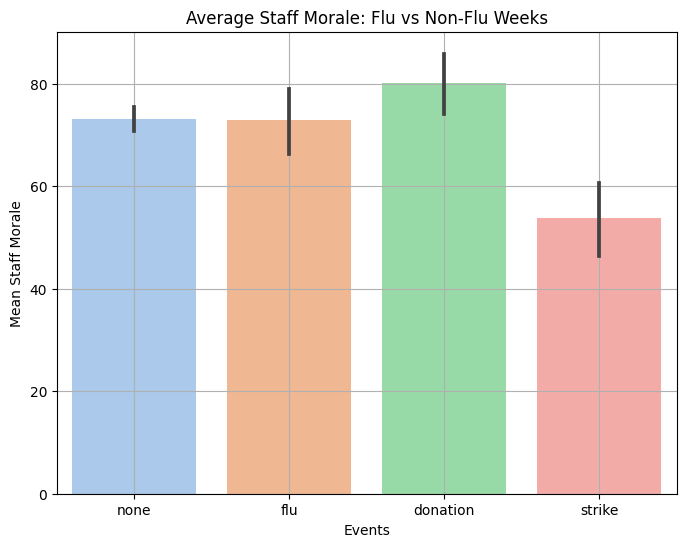

In [12]:
plt.figure(figsize=(8,6))
sns.barplot(x='event', y='staff_morale', data=services_weekly, palette='pastel', ci=95) #palette='pastel' - applies soft pastel colors for clear distinction and visual appeal.
                                                                                        #ci=95 - adds 95% confidence intervals as error bars, showing the uncertainty around each mean.
plt.title('Average Staff Morale: Flu vs Non-Flu Weeks')
plt.xlabel('Events')
plt.ylabel('Mean Staff Morale')
plt.grid()
plt.show()

**> Interpretation:**

1. both bars are similar and their error bars overlap, it indicates no significant difference in morale between the two conditions.
2. The error bars (the thin lines on top of each bar) represent the 95% confidence interval, meaning we’re 95% confident that the true average morale lies within that range.

# 3.Experimental Design

In [13]:
staff = pd.read_csv('/kaggle/input/hospital-beds-management/staff.csv')
staff.head()

,staff_id,staff_name,role,service
0,STF-5ca26577,Allison Hill,doctor,emergency
1,STF-02ae59ca,Noah Rhodes,doctor,emergency
2,STF-d8006e7c,Angie Henderson,doctor,emergency
3,STF-212d8b31,Daniel Wagner,doctor,emergency
4,STF-107a58e4,Cristian Santos,doctor,emergency


* Assigning Staff to Test Different Hospital Process Changes.


**This snippet demonstrates how to use experimental design principles to assign hospital staff to two process groups (A and B) for testing different operational changes.It ensures fair and randomized distribution across services and roles, a key practice in controlled experiments.**


In [14]:
np.random.seed(42) #Sets a random seed to make the random assignments reproducible.

staff["process_group"] = np.random.choice(["A", "B"], size=len(staff))
#Randomly assigns each staff member to either:
                                             ##Group A: testing process change A
                                             ##Group B: testing process change B
#size=len(staff) ensures every staff member is assigned to one of the two groups.
#The new column "process_group" stores each person’s assignment.

group_summary = staff.groupby(["process_group", "service", "role"]).size().unstack(fill_value=0)
#.size() counts how many staff fall into each combination.
#.unstack(fill_value=0) reshapes the table for easier reading and fills missing combinations with 0.

print(group_summary)

#Saves the updated DataFrame (now with the process_group column) to a new csv file.
#The file name "experimental_design_assignments.csv" records each staff member’s group assignment.
#index=False prevents pandas from writing row numbers to the file.
staff.to_csv("experimental_design_assignments.csv", index=False)
print("Staff assignments saved!")

role                            doctor  nurse  nursing_assistant
process_group service                                           
A             ICU                    3      5                  1
              emergency              4     10                  0
              general_medicine       1     11                  1
              surgery                2      6                  2
B             ICU                    3     13                  7
              emergency              1      9                  5
              general_medicine       2      8                  4
              surgery                2      7                  3
Staff assignments saved!


**> Interpretation:**

The ICU has more staff in one group (Group B) than the other. That creates an imbalance, which could:

1. Affect how process changes perform (since group B has more ICU staff).

2. Reduce the comparability between groups.

In experimental design, group balance ensures that any observed differences between groups are due to the process changes: not because one group has more ICU staff (or more of any specific service).

* Balancing Staff Assignments Across Process Groups and showing how many staff from each service belong to each process group.

**After balancing and assigning each staff member to either Process Group A and B, we can visualize how those assignments are distributed across hospital services. This ensures that both groups are balanced (*fairly distributed*) witch  is a crucial part of good experimental design.**


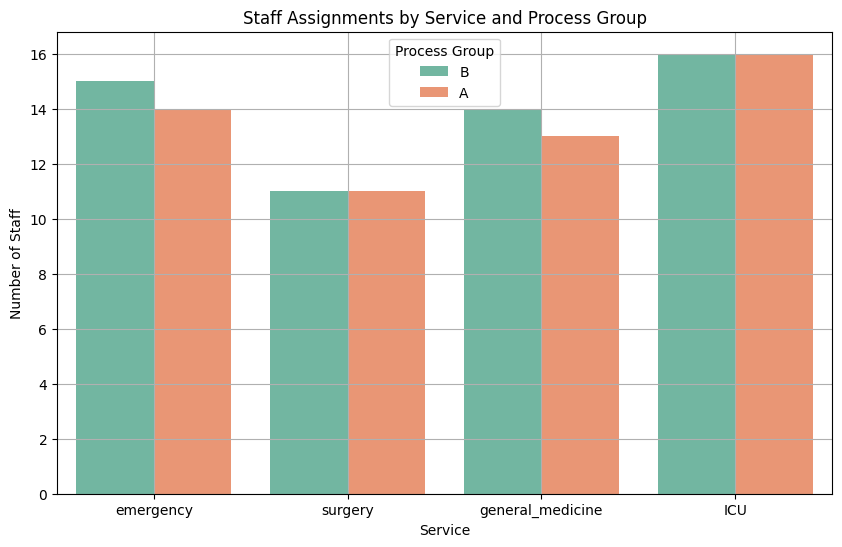

In [15]:
from sklearn.model_selection import train_test_split 
#This function from scikit-learn helps split data into random groups while maintaining structure: perfect for experimental balance.

#Initializes a new empty column process_group in the staff DataFrame.
staff['process_group'] = None       #This will later store “A” or “B” for each staff member.

#Goes through every unique hospital service (eg: icu, emergency, surgery).
#This ensures each service is processed separately for balanced assignment.
for service in staff['service'].unique():
    subset = staff[staff['service'] == service]  #Filters staff to include only those working in the current service.
    #Randomly divides each service’s staff into two equal halves:
                                                                ##train - becomes Process Group A
                                                                ##test - becomes Process Group B
#The random_state=42 ensures the split is reproducible every time you run it.
    train, test = train_test_split(subset, test_size=0.5, random_state=42)
    
    #Updates the main staff DataFrame with the new assignments.
    #Ensures each service, including ICU, has an equal number of staff in each process group.
    staff.loc[train.index, 'process_group'] = 'A'
    staff.loc[test.index, 'process_group'] = 'B'

plt.figure(figsize=(10, 6))
sns.countplot(data=staff, x="service", hue="process_group", palette="Set2")
plt.title("Staff Assignments by Service and Process Group")
plt.xlabel("Service")
plt.ylabel("Number of Staff")
plt.legend(title="Process Group")
plt.grid()
plt.show()

> Outcome

This method produces a balanced experimental design, every hospital service contributes staff equally to both groups.

Reduces bias and ensures fair comparison between Process A and Process B.

Especially important for smaller or specialized services like ICU, where imbalance can distort results.